# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 682 kB/s 
     |████████████████████████████████| 8.2 MB 1.5 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 814 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymorphy2
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations
from itertools import combinations
from scipy.stats import ttest_ind

# plt
import matplotlib.pyplot as plt
#увеличим размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


import collections
import seaborn as sns

import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок


In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info','productionDate']]).iterrows():
        query = f"model_info == '{row[0]}' and productionDate == {row[1]}"
        predicts.append(data_train.query(query)['price'].median())
        
# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Посмотрим, как выглядят распределения числовых признаков:

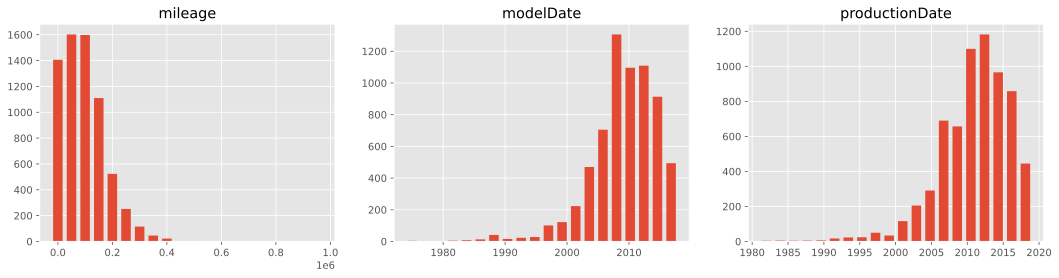

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итог:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [15]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
data.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

### Владение

In [18]:
data['Владение'].value_counts()

1 год и 8 месяцев      67
1 год и 2 месяца       67
1 год                  55
1 год и 10 месяцев     52
2 года и 2 месяца      52
                       ..
18 лет и 7 месяцев      1
14 лет и 5 месяцев      1
17 лет и 4 месяца       1
11 лет и 6 месяцев      1
16 лет и 10 месяцев     1
Name: Владение, Length: 180, dtype: int64

Очень много пропусков. Особого смысла не несёт. Лучше удалить.

### Владельцы

In [19]:
data['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [20]:
c_1 = collections.Counter(data['Владельцы'])
data['Владельцы'].fillna(c_1.most_common()[0][0], inplace=True)

In [21]:
data.Владельцы = data.Владельцы.apply(lambda x: x[0])

In [22]:
data['Владельцы'].value_counts()

3    3312
1    2526
2    2515
Name: Владельцы, dtype: int64

### bodyType

In [23]:
data['bodyType'].value_counts()

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

### brand

In [24]:
data['brand'].value_counts()

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

### engineDisplacement

In [25]:
collections.Counter(data['engineDisplacement'])

Counter({'3.0 LTR': 2349,
         '2.5 LTR': 248,
         '2.0 LTR': 2430,
         '3.5 LTR': 250,
         '1.8 LTR': 411,
         '2.2 LTR': 58,
         '5.5 LTR': 268,
         '4.8 LTR': 57,
         '1.6 LTR': 410,
         '4.7 LTR': 137,
         '4.0 LTR': 153,
         '1.5 LTR': 73,
         '2.4 LTR': 44,
         '1.4 LTR': 106,
         '2.1 LTR': 221,
         '5.2 LTR': 13,
         '4.4 LTR': 329,
         '2.8 LTR': 106,
         '4.2 LTR': 103,
         '3.2 LTR': 60,
         '6.0 LTR': 37,
         '3.7 LTR': 14,
         '5.0 LTR': 74,
         '1.2 LTR': 33,
         '3.6 LTR': 23,
         '2.3 LTR': 14,
         '6.2 LTR': 40,
         '1.7 LTR': 15,
         '1.3 LTR': 32,
         '5.4 LTR': 33,
         '3.1 LTR': 44,
         '2.6 LTR': 9,
         '3.8 LTR': 3,
         '4.1 LTR': 23,
         '2.9 LTR': 50,
         '6.6 LTR': 5,
         '5.9 LTR': 11,
         'undefined LTR': 6,
         '2.7 LTR': 24,
         '0.7 LTR': 6,
         '1.9 LTR': 5,


In [26]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: float((x.split(' ')[0])))
data['engineDisplacement'].value_counts()

2.0    2436
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
3.5     250
2.5     248
2.1     221
4.0     153
4.7     137
2.8     106
1.4     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
3.1      44
2.4      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
3.6      23
4.1      23
1.7      15
3.7      14
2.3      14
5.2      13
5.9      11
2.6       9
0.7       6
1.9       5
5.8       5
6.6       5
4.6       5
4.3       4
3.4       4
6.3       3
3.8       3
5.6       3
4.9       2
Name: engineDisplacement, dtype: int64

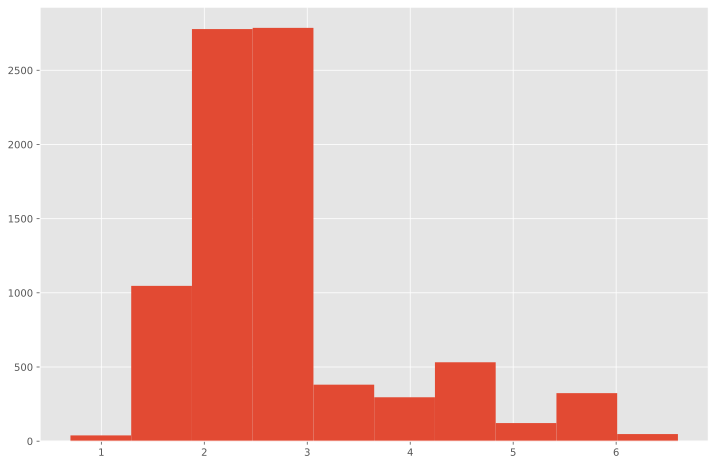

In [27]:
data['engineDisplacement'].hist()

In [28]:
#нормализуем данные
data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)

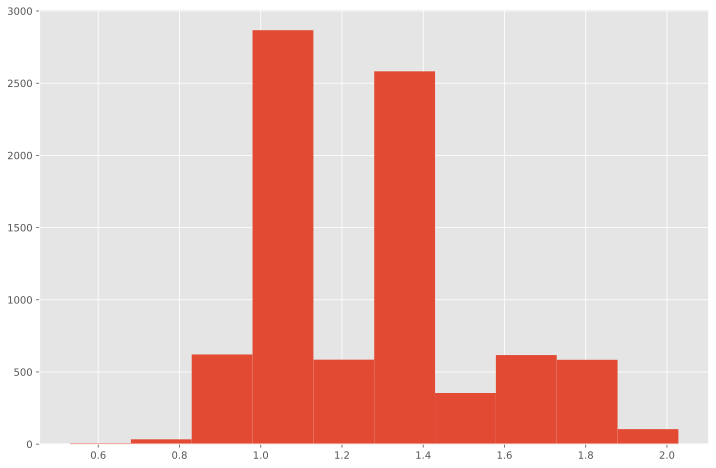

In [29]:
data['engineDisplacement'].hist()

### enginePower

In [30]:
collections.Counter(data['enginePower'])

Counter({'220 N12': 33,
         '313 N12': 66,
         '218 N12': 233,
         '136 N12': 200,
         '190 N12': 420,
         '340 N12': 78,
         '245 N12': 355,
         '316 N12': 3,
         '170 N12': 274,
         '160 N12': 83,
         '231 N12': 179,
         '388 N12': 82,
         '180 N12': 145,
         '367 N12': 105,
         '115 N12': 62,
         '184 N12': 759,
         '177 N12': 129,
         '455 N12': 60,
         '422 N12': 14,
         '163 N12': 63,
         '249 N12': 655,
         '272 N12': 206,
         '224 N12': 92,
         '122 N12': 95,
         '557 N12': 37,
         '333 N12': 160,
         '306 N12': 344,
         '156 N12': 223,
         '150 N12': 278,
         '264 N12': 18,
         '450 N12': 73,
         '555 N12': 53,
         '407 N12': 93,
         '130 N12': 25,
         '400 N12': 25,
         '204 N12': 174,
         '469 N12': 19,
         '192 N12': 74,
         '210 N12': 10,
         '211 N12': 310,
         '239 N12': 23,

In [31]:
data['enginePower'] = data['enginePower'].str.split().apply(lambda x: x[0]) 
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

In [32]:
data['enginePower'] /= 100

In [33]:
data['enginePower'].value_counts()

1.84    759
2.49    655
1.90    420
2.45    355
3.06    344
       ... 
5.91      1
1.74      1
5.20      1
1.66      1
0.98      1
Name: enginePower, Length: 154, dtype: int64

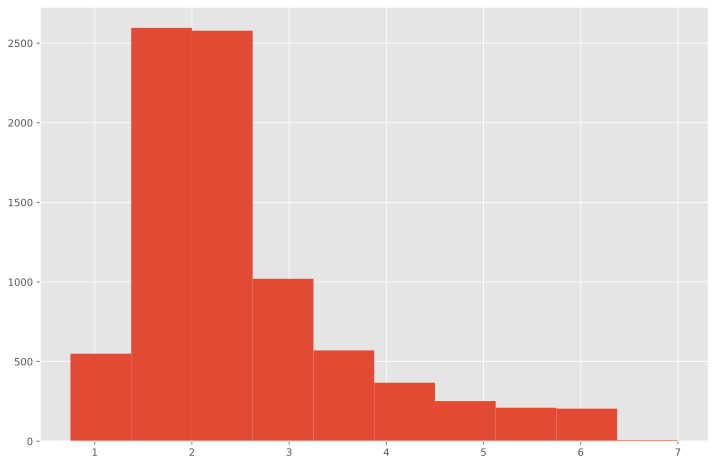

In [34]:
data['enginePower'].hist()

In [35]:
#нормализуем данные
data['enginePower'] = np.log(data['enginePower'] + 1)

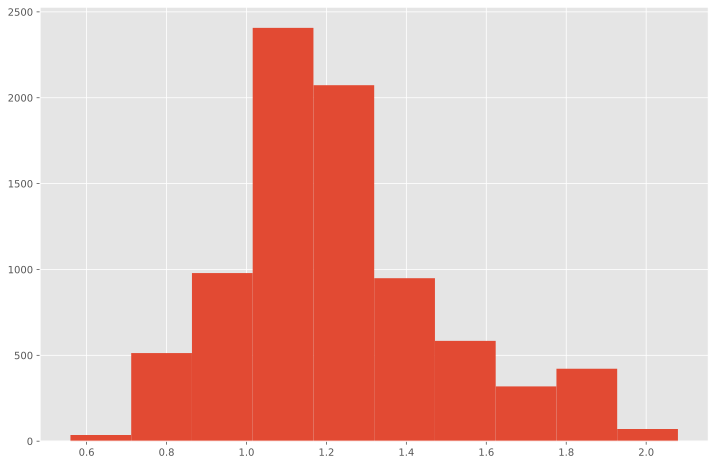

In [36]:
data['enginePower'].hist()

### mileage

In [37]:
data['mileage'].describe()

count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

In [38]:
#неплохо разбить пробег по категориям и ввести новый признак 
def mile_age(x):
    if x < 25000: x = 1
    elif 24999 < x < 50000: x = 2
    elif 49999 < x < 100000: x = 3
    elif 99999 < x < 150000: x = 4
    elif 149999 < x < 250000: x = 5
    elif 249999 < x < 500000: x = 6
    elif 499999 < x: x = 7
    return x  
data['mileage_category'] = data['mileage'].map(mile_age)

In [39]:
data['mileage_category'].value_counts()

5    2073
3    2004
4    1962
1     924
2     811
6     572
7       7
Name: mileage_category, dtype: int64

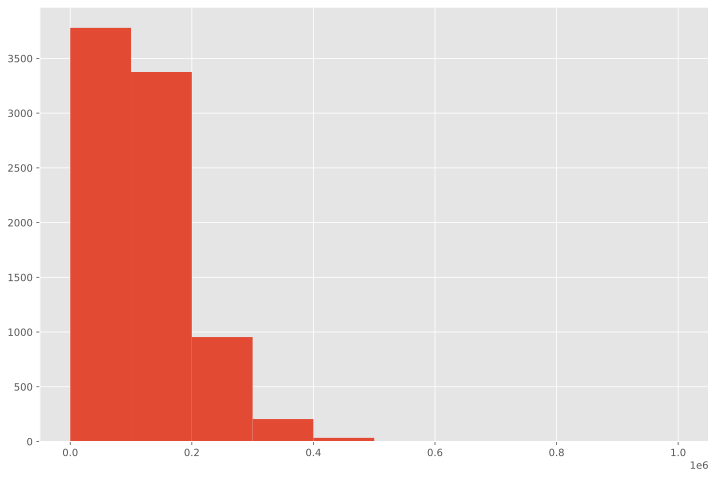

In [40]:
data['mileage'].hist()

In [41]:
#нормализуем данные
data['mileage'] = np.log(data['mileage'])

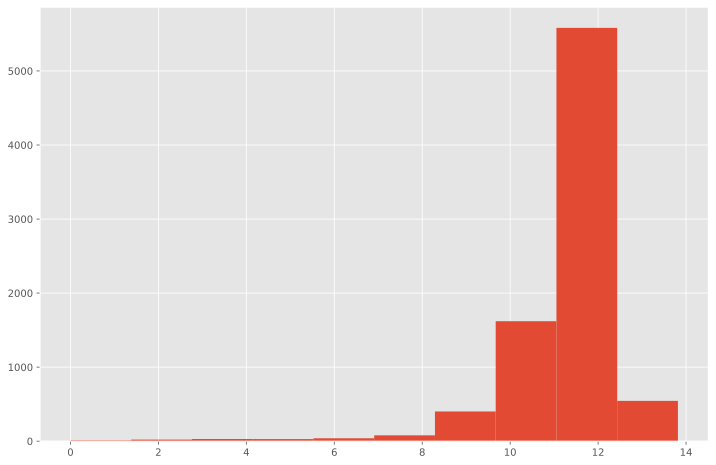

In [42]:
data['mileage'].hist()

### productionDate

In [43]:
data['productionDate'].describe()

count    8353.000000
mean     2012.010775
std         5.107314
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

In [44]:
#неплохо разбить возраст по категориям и ввести новый признак
def product_age(x):
    if x > 2017: x = 1
    elif 2018 > x > 2015: x = 2
    elif 2016 > x > 2013: x = 3
    elif 2014 > x > 2004: x = 4
    elif 2005 > x: x = 5
    return x  
data['age_cat'] = data['productionDate'].map(product_age)

In [45]:
data['age_cat'].value_counts()

4    4183
3    1292
2    1162
1    1078
5     638
Name: age_cat, dtype: int64

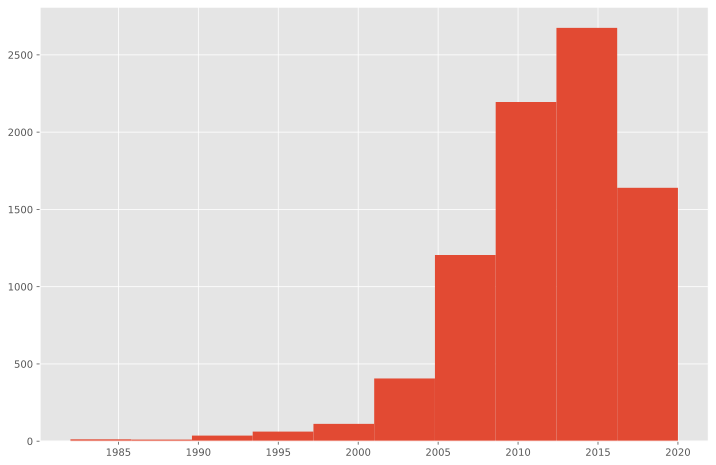

In [46]:
data['productionDate'].hist()

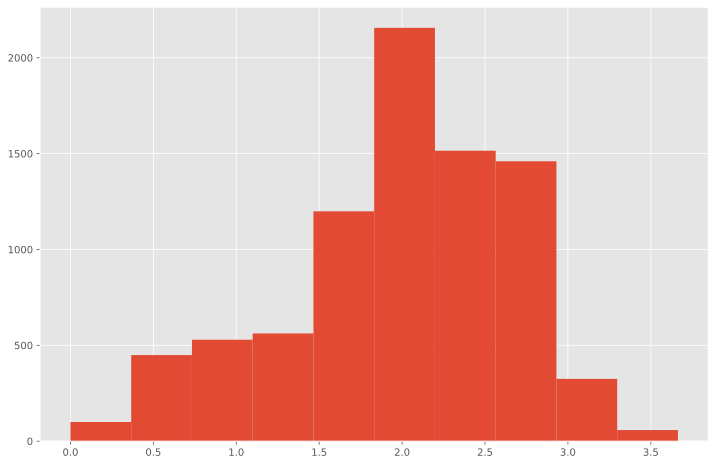

In [47]:
data['productionDate'] = np.log(2021 - data['productionDate'])
data['productionDate'].hist()

### modelDate

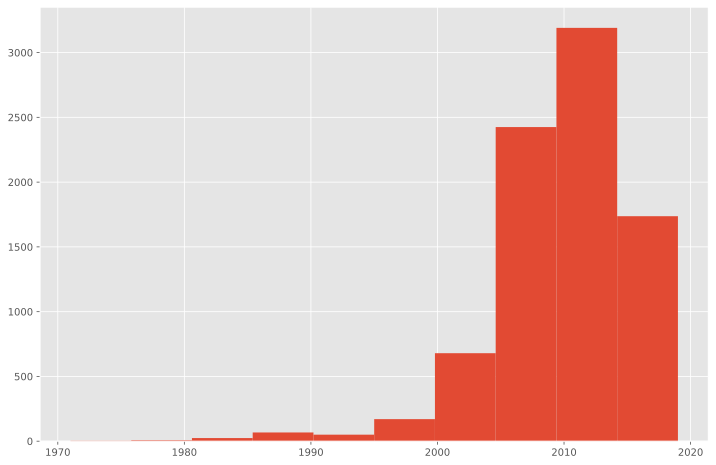

In [48]:
data['modelDate'].hist()

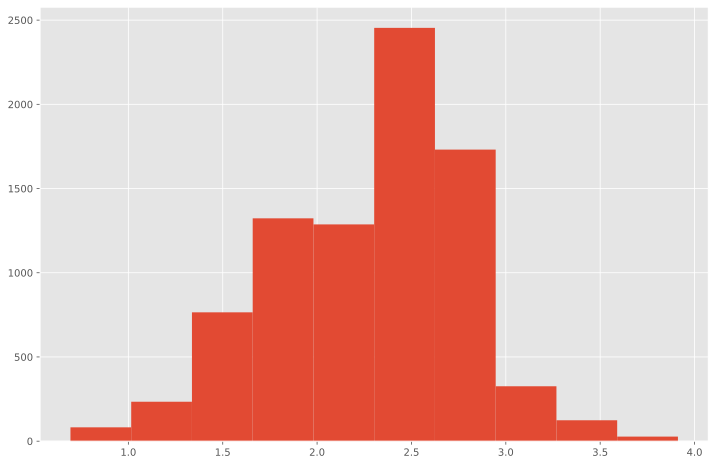

In [49]:
data['modelDate'] = np.log(2021 - data['modelDate'])
data['modelDate'].hist()

### name

In [50]:
data.name

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
8348                320i 2.0 AT (150 л.с.)
8349               520d 2.0d AT (190 л.с.)
8350                318i 2.0 AT (143 л.с.)
8351            Long 3.0 AT (310 л.с.) 4WD
8352             Pullman 6.0 AT (394 л.с.)
Name: name, Length: 8353, dtype: object

#### Добавим признаки полного привода

In [51]:
data['4wd'] = data['name'].apply(lambda x: 1 if '4WD' in x else 0)

In [52]:
data['4wd'].value_counts()

1    5218
0    3135
Name: 4wd, dtype: int64

In [53]:
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
data['xdrive'].value_counts()

0    7414
1     939
Name: xdrive, dtype: int64

In [54]:
data.drop(['Владение','vehicleConfiguration', 'name'], axis = 1, inplace=True)

In [55]:
data.nunique()

bodyType                 17
brand                     3
color                    16
description            7654
engineDisplacement       47
enginePower             154
fuelType                  4
mileage                3507
modelDate                43
model_info              122
numberOfDoors             4
productionDate           39
sell_id                8353
vehicleTransmission       4
Владельцы                 3
ПТС                       2
Привод                    3
Руль                      2
sample                    2
price                  1629
mileage_category          7
age_cat                   5
4wd                       2
xdrive                    2
dtype: int64

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8353 non-null   object 
 1   brand                8353 non-null   object 
 2   color                8353 non-null   object 
 3   description          8353 non-null   object 
 4   engineDisplacement   8353 non-null   float64
 5   enginePower          8353 non-null   float64
 6   fuelType             8353 non-null   object 
 7   mileage              8353 non-null   float64
 8   modelDate            8353 non-null   float64
 9   model_info           8353 non-null   object 
 10  numberOfDoors        8353 non-null   int64  
 11  productionDate       8353 non-null   float64
 12  sell_id              8353 non-null   int64  
 13  vehicleTransmission  8353 non-null   object 
 14  Владельцы            8353 non-null   object 
 15  ПТС                  8353 non-null   o

In [57]:
#обновляем список категориальных
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', '4wd', 'xdrive', 'numberOfDoors',
                        'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'mileage_category', 'age_cat']

#обновляем список числовых признаков
numerical_features = ['mileage', 'modelDate', 'enginePower', 'engineDisplacement', 'productionDate']

In [58]:
corr = data[numerical_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,mileage,modelDate,enginePower,engineDisplacement,productionDate
mileage,1.000,0.639,-0.152,0.023,0.722
modelDate,0.639,1.000,-0.094,0.187,0.938
enginePower,-0.152,-0.094,1.000,0.874,-0.071
engineDisplacement,0.023,0.187,0.874,1.000,0.192
productionDate,0.722,0.938,-0.071,0.192,1.000


modelDate и productionDate очень коррелируют, но лучше оставить.

In [59]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [60]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,...,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4
7399,0.379283,0.446603,0.838231,0.389193,0.489076,1,1590000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4273,0.379283,0.446603,0.775535,0.430677,0.439310,1,3100000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0
3362,0.895597,0.897888,0.790060,0.430677,0.489076,1,3750000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2794,0.571389,0.446603,0.849485,0.500000,0.628510,1,1990000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0
5378,0.379283,0.392983,0.862198,0.430677,0.489076,1,1285000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
5902,0.720397,0.873425,0.807309,0.467268,0.567601,1,3399999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
1454,0.571389,0.576032,0.787059,0.467268,0.489076,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2476,0.482220,0.392983,0.873217,0.604531,0.700125,1,700000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
743,0.283725,0.135445,0.846530,0.604531,0.654526,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1168,0.895597,0.857278,0.759384,0.467268,0.531153,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0


In [61]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 203 entries, engineDisplacement to age_cat_4
dtypes: float64(6), int64(1), uint8(196)
memory usage: 2.0 MB


## Split data

In [62]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [63]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 202 entries, engineDisplacement to age_cat_4
dtypes: float64(6), uint8(196)
memory usage: 411.2 KB


# Model 2: CatBoostRegressor

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [65]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.05,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.9667519	test: 0.9900709	best: 0.9900709 (0)	total: 55ms	remaining: 4m 34s
100:	learn: 0.2228555	test: 0.2216869	best: 0.2215818 (99)	total: 352ms	remaining: 17.1s
200:	learn: 0.1778893	test: 0.1795918	best: 0.1795918 (200)	total: 646ms	remaining: 15.4s
300:	learn: 0.1629403	test: 0.1664607	best: 0.1664607 (300)	total: 935ms	remaining: 14.6s
400:	learn: 0.1495280	test: 0.1558734	best: 0.1558706 (399)	total: 1.24s	remaining: 14.2s
500:	learn: 0.1396790	test: 0.1474122	best: 0.1474122 (500)	total: 1.55s	remaining: 14s
600:	learn: 0.1333208	test: 0.1420443	best: 0.1420443 (600)	total: 1.86s	remaining: 13.6s
700:	learn: 0.1271522	test: 0.1375746	best: 0.1375746 (700)	total: 2.16s	remaining: 13.2s
800:	learn: 0.1231971	test: 0.1353587	best: 0.1352900 (794)	total: 2.46s	remaining: 12.9s
900:	learn: 0.1196216	test: 0.1338018	best: 0.1338018 (900)	total: 2.75s	remaining: 12.5s
1000:	learn: 0.1161847	test: 0.1317274	best: 0.1316831 (998)	total: 3.05s	remaining: 12.2s
1100:	learn: 0.1

In [66]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.36%


MAPE улучшился до 12.36

### Submission

In [67]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [68]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,...,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4
7320,0.945084,0.857278,0.862682,0.581508,0.628510,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
8037,0.379283,0.446603,0.720170,0.284662,0.299875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0
4681,0.587878,0.465403,0.854462,0.664849,0.739185,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0
6014,0.333212,0.318581,0.919752,0.625965,0.720353,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3649,0.571389,0.564974,0.850062,0.500000,0.567601,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0


## Simple Dense NN

In [69]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
        l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.000000001, 
        l2=0.000000001), activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               103424    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 235,009
Trainable params: 235,009
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [72]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [73]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
12/12 [==============================] - 0s 20ms/step - loss: 99.9930 - MAPE: 99.9930 - val_loss: 99.9476 - val_MAPE: 99.9476
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 99.7547 - MAPE: 99.7546 - val_loss: 99.1764 - val_MAPE: 99.1763
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 98.0314 - MAPE: 98.0314 - val_loss: 95.3902 - val_MAPE: 95.3902
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 91.7179 - MAPE: 91.7178 - val_loss: 83.9874 - val_MAPE: 83.9873
Epoch 5/500
12/12 [==============================] - 0s 6ms/step - loss: 75.1374 - MAPE: 75.1373 - val_loss: 60.4606 - val_MAPE: 60.4605
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 54.3261 - MAPE: 54.3260 - val_loss: 49.9244 - val_MAPE: 49.9242
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 50.1646 - MAPE: 50.1644 - val_loss: 49.0109 - val_MAPE: 49.0107
Epoch 8/500
12/12 [=====================

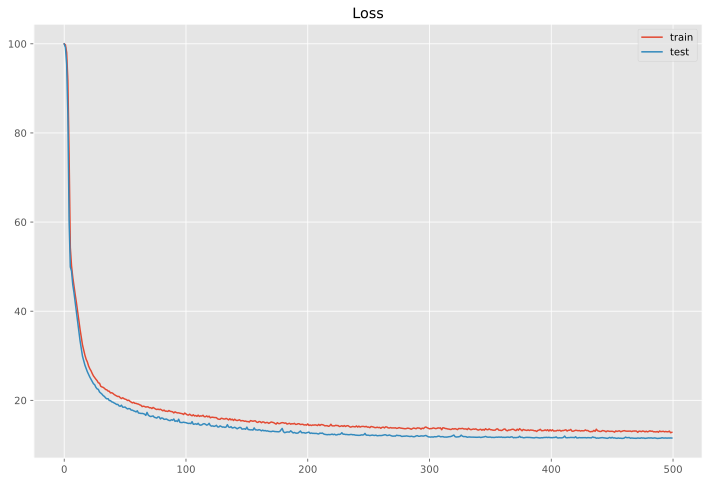

In [74]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [75]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [76]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.54%


MAPE улучшился до 11.45

In [77]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [78]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [79]:
#проведем лемматизацию
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [80]:
data['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [81]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [82]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [83]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.41 s, sys: 8.82 ms, total: 1.42 s
Wall time: 1.42 s


In [84]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'автомобиль': 6,
 'не': 7,
 'по': 8,
 'система': 9,
 'задний': 10,
 'всё': 11,
 'пробег': 12,
 'салон': 13,
 'сидение': 14,
 'для': 15,
 'передний': 16,
 'от': 17,
 'машина': 18,
 'до': 19,
 'у': 20,
 '2': 21,
 'комплект': 22,
 'при': 23,
 'год': 24,
 'официальный': 25,
 'без': 26,
 'ваш': 27,
 'кредит': 28,
 'вы': 29,
 'диск': 30,
 'новый': 31,
 'авто': 32,
 'состояние': 33,
 'пакет': 34,
 'фара': 35,
 'безопасность': 36,
 'руль': 37,
 'за': 38,
 'колесо': 39,
 'дилер': 40,
 'гарантия': 41,
 'состоянии': 42,
 'птс': 43,
 'обмен': 44,
 'контроль': 45,
 'то': 46,
 'комплектация': 47,
 'bmw': 48,
 'быть': 49,
 '000': 50,
 'из': 51,
 'два': 52,
 'более': 53,
 'полный': 54,
 'весь': 55,
 'покупка': 56,
 'зеркало': 57,
 'датчик': 58,
 '1': 59,
 'есть': 60,
 'только': 61,
 'мы': 62,
 'продажа': 63,
 'отличный': 64,
 'автомобиля': 65,
 'один': 66,
 'водитель': 67,
 'подушка': 68,
 'шина': 69,
 'пассажир': 70,
 '6': 71,
 'двигатель': 72,
 'хороший

In [85]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.47 s, sys: 8.83 ms, total: 1.48 s
Wall time: 1.48 s


In [86]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

. • автомобиль проверить по 110 пункт • автокредит по специальный ставка от 13,7% ауди центр север, официальный дилер audi, входящий в группа компания рольф и являться один из крупный дилер в европе, предлагать вы ряд услуга по покупка и продажа автомобиль с пробегом. на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер audi в россия и предоставлять клиент самый большой выбор автомобиль с пробег audi и другой марок. каждый автомобиль проходить тщательный диагностик и подготовку, и гарантировать находиться в отличный состоянии. чтобы убедиться в правильный выборе, у вы есть возможность пройти тест-драйв ― ознакомительный поездка на интересовать автомобиле. вы смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести online презентация и в видеозвонок показать выбрать автомобиль. также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условиях. специалист компа

### RNN NLP

In [87]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [88]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [89]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [90]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8131328     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [91]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [92]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [93]:
%%time
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 342ms/step - loss: 99.9743 - MAPE: 99.9743 - val_loss: 99.6990 - val_MAPE: 99.6990
Epoch 2/500
12/12 [==============================] - 4s 299ms/step - loss: 97.4629 - MAPE: 97.4629 - val_loss: 88.7005 - val_MAPE: 88.7005
Epoch 3/500
12/12 [==============================] - 3s 285ms/step - loss: 68.9069 - MAPE: 68.9069 - val_loss: 53.6066 - val_MAPE: 53.6066
Epoch 4/500
12/12 [==============================] - 3s 281ms/step - loss: 52.0036 - MAPE: 52.0036 - val_loss: 46.7498 - val_MAPE: 46.7498
Epoch 5/500
12/12 [==============================] - 4s 295ms/step - loss: 45.8230 - MAPE: 45.8230 - val_loss: 41.6011 - val_MAPE: 41.6011
Epoch 6/500
12/12 [==============================] - 4s 301ms/step - loss: 40.5552 - MAPE: 40.5552 - val_loss: 37.3948 - val_MAPE: 37.3948
Epoch 7/500
12/12 [==============================] - 4s 294ms/step - loss: 36.1122 - MAPE: 36.1122 - val_loss: 31.6025 - val_MAPE: 31.6025
Epoch 8/500
12/12 [========

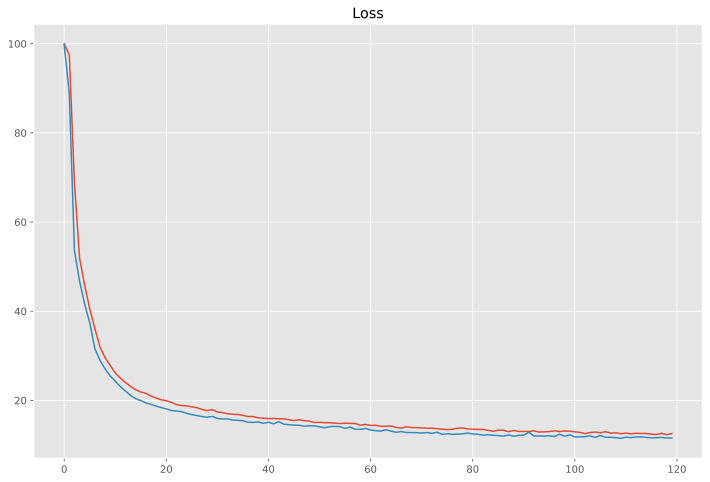

In [94]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [95]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [96]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.57%


In [97]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

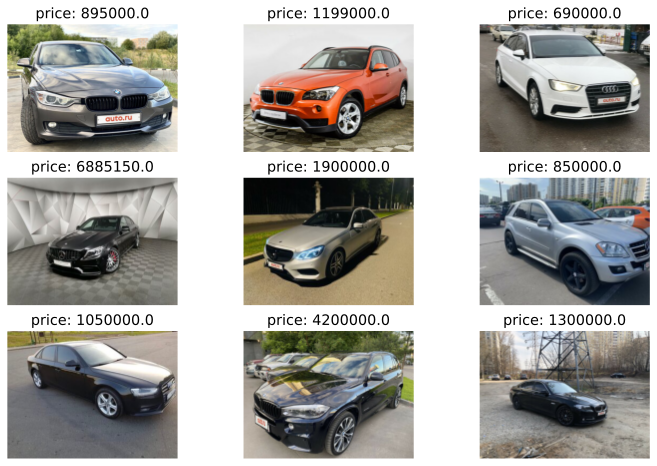

In [98]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [99]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

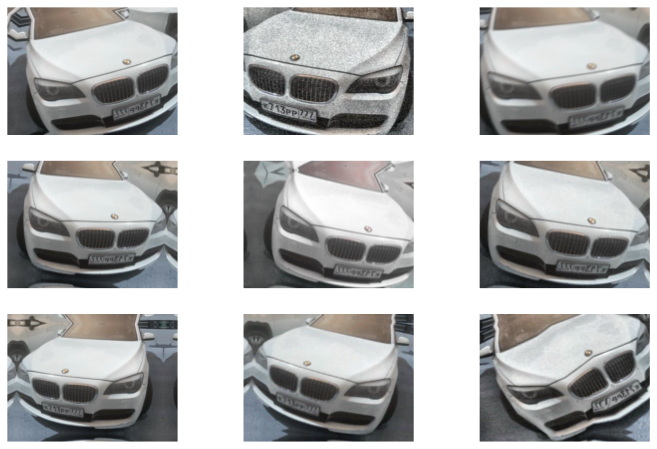

In [100]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Rotate,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [101]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [102]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [103]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [104]:
#нормализация включена в состав модели EfficientNetB6, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3)
)
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

165240832/165234480 [==============================] - 1s 0us/step


In [105]:
print("Number of layers in the base model: ", len(efficientnet_model.layers))

Number of layers in the base model:  666


In [106]:
# Fine-tuning.
efficientnet_model.trainable = True

fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [107]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ee5516c90> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f9e5468ca50> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f9e78d2db10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9ebc080410> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ebc0b9750> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f9e5444fd90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9e54505bd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9e54581fd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9e54505b90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9e545a9550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9ebc067650> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9e544fdfd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0

In [108]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [109]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [110]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [111]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [112]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [113]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=80,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/80
190/190 [==============================] - 133s 699ms/step - loss: 50.5398 - MAPE: 50.5398 - val_loss: 27.2033 - val_MAPE: 27.2033
Epoch 2/80
190/190 [==============================] - 125s 655ms/step - loss: 24.9459 - MAPE: 24.9459 - val_loss: 21.6116 - val_MAPE: 21.6116
Epoch 3/80
190/190 [==============================] - 128s 671ms/step - loss: 22.0917 - MAPE: 22.0917 - val_loss: 20.5005 - val_MAPE: 20.5005
Epoch 4/80
190/190 [==============================] - 125s 657ms/step - loss: 20.1503 - MAPE: 20.1503 - val_loss: 19.4596 - val_MAPE: 19.4596
Epoch 5/80
190/190 [==============================] - 128s 676ms/step - loss: 18.9056 - MAPE: 18.9056 - val_loss: 17.5329 - val_MAPE: 17.5329
Epoch 6/80
190/190 [==============================] - 129s 679ms/step - loss: 18.1388 - MAPE: 18.1388 - val_loss: 18.3688 - val_MAPE: 18.3688
Epoch 7/80
190/190 [==============================] - 127s 667ms/step - loss: 17.3451 - MAPE: 17.3451 - val_loss: 18.8169 - val_MAPE: 18.8169
Epoch 

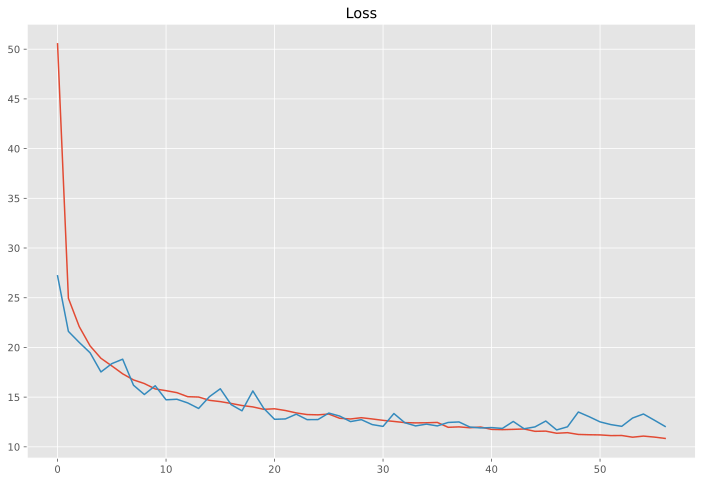

In [114]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [115]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [116]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.05%


In [117]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [118]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.89%


In [119]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [120]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [121]:
# FEATURE Input
# Iput
engineDisplacement = L.Input(shape=[1], name="engineDisplacement")

emb_engineDisplacement = L.Embedding(
    len(X.engineDisplacement.unique().tolist())+1, 20
)(engineDisplacement)

f_engineDisplacement = L.Flatten()(emb_engineDisplacement)

In [122]:
combinedInput = L.concatenate([model_mlp.output, f_engineDisplacement,])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_mlp.input, engineDisplacement], outputs=head)

In [123]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 201)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          103424      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
engineDisplacement (InputLayer) [(None, 1)]          0                                            
_______________________________________________________________________________________

In [124]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [125]:
%%time
history = model.fit(
    [X_train, X_train.engineDisplacement.values],
    y_train,
    batch_size=512,
    epochs=500,
    validation_data=([X_test, X_test.engineDisplacement.values], y_test),
    callbacks=callbacks_list
)

Epoch 1/500
12/12 [==============================] - 0s 22ms/step - loss: 99.9789 - MAPE: 99.9789 - val_loss: 99.7547 - val_MAPE: 99.7547
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 97.9291 - MAPE: 97.9291 - val_loss: 90.6387 - val_MAPE: 90.6387
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 72.0345 - MAPE: 72.0345 - val_loss: 51.4423 - val_MAPE: 51.4423
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 53.0984 - MAPE: 53.0984 - val_loss: 46.7378 - val_MAPE: 46.7378
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 47.2019 - MAPE: 47.2019 - val_loss: 42.5418 - val_MAPE: 42.5418
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 41.6506 - MAPE: 41.6506 - val_loss: 37.9356 - val_MAPE: 37.9356
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 37.0829 - MAPE: 37.0829 - val_loss: 32.8997 - val_MAPE: 32.8997
Epoch 8/500
12/12 [=====================

In [126]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.engineDisplacement.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.21%
